In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!ls ~/git/analysis_playground/ml/data/training_data

ls: cannot access /SNS/users/imeliamb/git/analysis_playground/ml/data/training_data: No such file or directory


In [4]:
data_dir = os.path.expanduser("~m2d/git/analysis_playground/ml/data/training_data")

pars = np.load(os.path.join(data_dir, "orhs_pars.npy"))
refl = np.load(os.path.join(data_dir, "orhs_data.npy"))
q_values = np.load(os.path.join(data_dir, "orhs_q_values.npy"))

print(pars.shape)
print(refl.shape)
print(q_values.shape)

refl = np.power(10, refl)/q_values**2*q_values[0]**2

idx = 0


(1000000,)
(1000000, 100)
(100,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


index 0 [0.0]


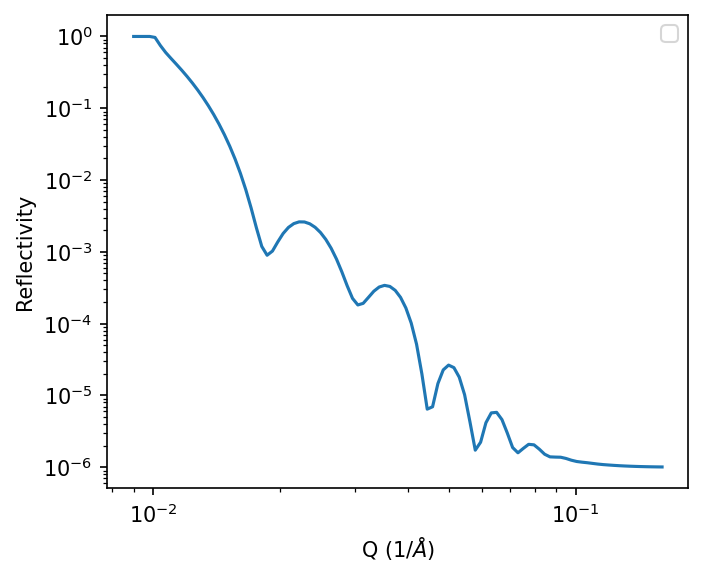

In [5]:
print("index %s [%s]" % (idx, pars[idx]))

fig, ax = plt.subplots(dpi=150, figsize=(5, 4.1))
plt.plot(q_values, refl[idx])
plt.xlabel('Q ($1/\AA$)', fontsize=10)
plt.ylabel('Reflectivity', fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.legend()
idx += 1